In [38]:
# Importing necessary libraries
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt

## Multi-Input Model (Siamese network)

### Prepare the Data

In [46]:
def create_pairs(x, digit_indices):
    pairs = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1

    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = np.random.randint(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]

    labels = [1, 0] * 10 * n
    return np.array(pairs), np.array(labels)

def create_pairs_on_set(images, labels):
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')

    return pairs, y

# load the dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# normalize values
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

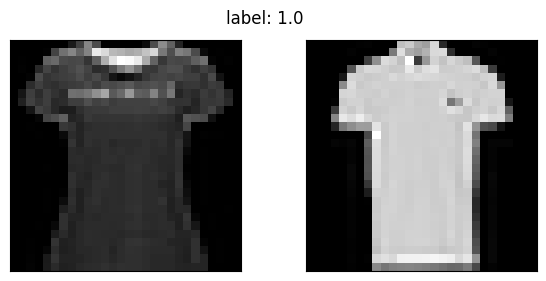

In [67]:
def show_image(image, ax):
    ax.imshow(image, "gray")
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

# array index
this_pair = 8

# show images at this index
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
show_image(ts_pairs[this_pair][0], ax=ax[0])
show_image(ts_pairs[this_pair][1], ax=ax[1])
plt.suptitle(f"label: {ts_y[this_pair]}");

### Build the Model

In [68]:
def initialize_base_network():
    input = tf.keras.layers.Input(shape=(28,28,), name="base_input")
    x = tf.keras.layers.Flatten(name="flatten_input")(input)
    x = tf.keras.layers.Dense(128, activation='relu', name="first_base_dense")(x)
    x = tf.keras.layers.Dropout(0.1, name="first_dropout")(x)
    x = tf.keras.layers.Dense(128, activation='relu', name="second_base_dense")(x)
    x = tf.keras.layers.Dropout(0.1, name="second_dropout")(x)
    x = tf.keras.layers.Dense(128, activation='relu', name="third_base_dense")(x)

    return tf.keras.models.Model(inputs=input, outputs=x)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

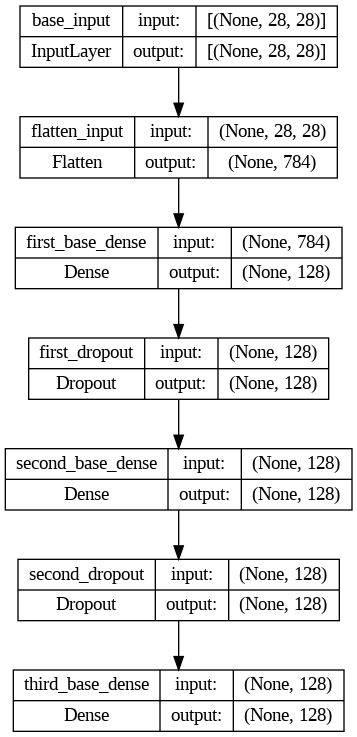

In [72]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True,
           show_layer_names=True)

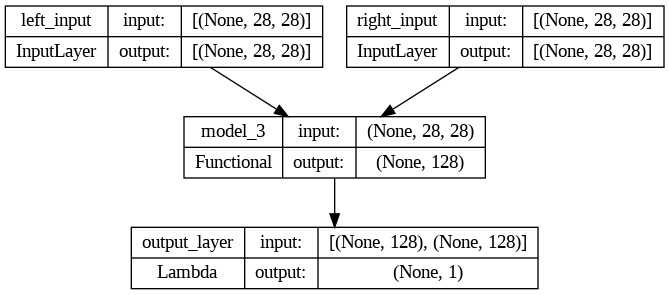

In [73]:
# create the left input and point to the base network
input_a = tf.keras.layers.Input(shape=(28,28,), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = tf.keras.layers.Input(shape=(28,28,), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = tf.keras.layers.Lambda(
    euclidean_distance, name="output_layer",
    output_shape=eucl_dist_output_shape
)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = tf.keras.models.Model([input_a, input_b], output)

# plot model graph
plot_model(model, show_shapes=True,
           show_layer_names=True)

### Train the Model

In [75]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

rms = tf.keras.optimizers.RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/20
938/938 [==============================] - 9s 8ms/step - loss: 0.1154 - val_loss: 0.0853
Epoch 2/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0815 - val_loss: 0.0773
Epoch 3/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0733 - val_loss: 0.0726
Epoch 4/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0685 - val_loss: 0.0704
Epoch 5/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0648 - val_loss: 0.0689
Epoch 6/20
938/938 [==============================] - 13s 14ms/step - loss: 0.0626 - val_loss: 0.0673
Epoch 7/20
938/938 [==============================] - 13s 14ms/step - loss: 0.0606 - val_loss: 0.0654
Epoch 8/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0590 - val_loss: 0.0648
Epoch 9/20
938/938 [==============================] - 11s 12ms/step - loss: 0.0576 - val_loss: 0.0644
Epoch 10/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0564 - val_loss:

### Model Evaluation

In [76]:
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 1s 2ms/step
Loss = 0.0629679337143898, Train Accuracy = 0.9407401233538923 Test Accuracy = 0.913913913913914


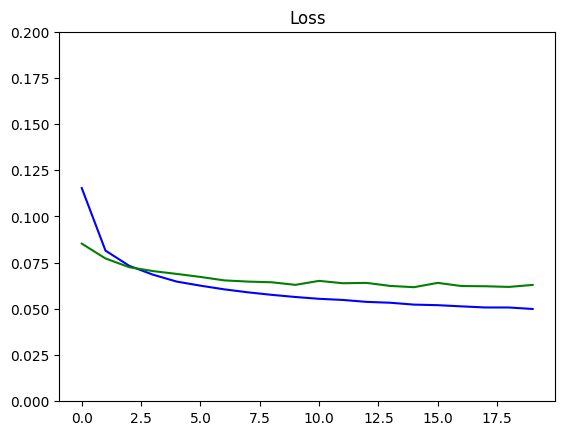

In [77]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [78]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

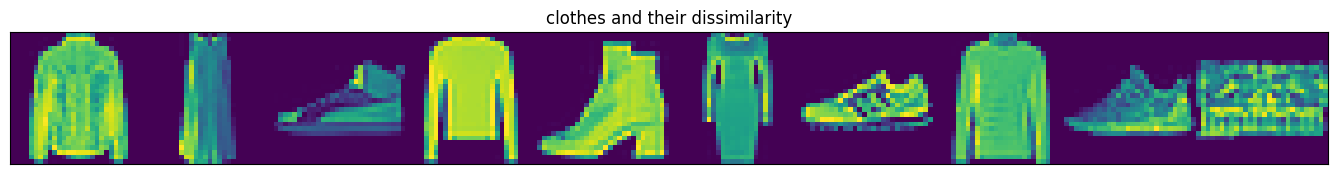

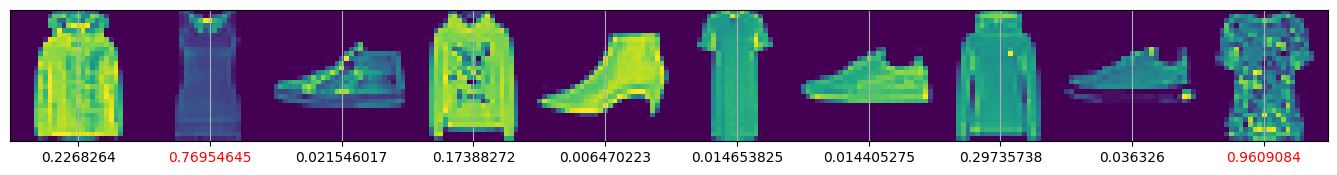

In [81]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)

## Multi-Output Model

### Prepare the Data

We download the dataset and format it for training.

In [82]:
!pip install ucimlrepo

In [83]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
energy_efficiency = fetch_ucirepo(id=242)

train_data, test_data, train_label, test_label, = train_test_split(
    energy_efficiency.data.features,
    energy_efficiency.data.targets,
    test_size=.2, random_state=42
)

data_mean, data_std = train_data.mean(), train_data.std()

train_data = (train_data - data_mean) / data_std
test_data = (test_data - data_mean) / data_std

train_label = train_label.values
test_label = test_label.values

### Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [84]:
# Define model layers.
input_layer = tf.keras.layers.Input(shape=(len(train_data.columns),))
x = tf.keras.layers.Dense(units='128', activation='relu')(input_layer)
x = tf.keras.layers.Dense(units='128', activation='relu')(x)

# Y1 output will be fed directly from the second dense
y1_output = tf.keras.layers.Dense(units='1', name='y1_output')(x)
x = tf.keras.layers.Dense(units='64', activation='relu')(x)

# Y2 output will come via the third dense
y2_output = tf.keras.layers.Dense(units='1', name='y2_output')(x)

# Define the model with the input layer and a list of output layers
model = tf.keras.models.Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  1152      ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 128)                  16512     ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 64)                   8256      ['dense_1[0][0]']             
                                                                                            

### Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [86]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

### Train the model

In [ ]:
# Train the model for 500 epochs
history = model.fit(train_data, train_label,
                    epochs=500, batch_size=10,
                    validation_data=(test_data, test_label))

### Evaluate the Model and Plot Metrics

5/5 [==============================] - 0s 6ms/step - loss: 8.2080 - y1_output_loss: 3.8359 - y2_output_loss: 4.3721 - y1_output_root_mean_squared_error: 1.9585 - y2_output_root_mean_squared_error: 2.0910
Loss = 8.20798397064209, Y1_loss = 3.835871696472168, Y1_mse = 1.9585380554199219, Y2_loss = 4.372112274169922, Y2_mse = 2.0909595489501953
5/5 [==============================] - 0s 3ms/step


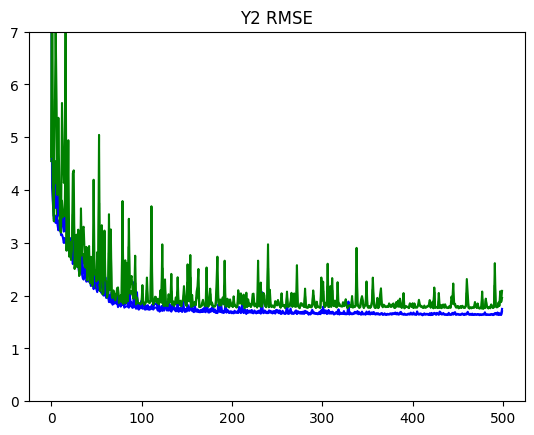

In [89]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)

# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=test_data, y=test_label)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

# Plot the loss and mse
Y_pred = model.predict(test_data)
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)